# GSL Test Pipeline

In [3]:
#### Imports

import os
import random
random.seed(123)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchsummary import summary

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import models.models as M

## Hyperparams

In [4]:
#### Hyper Parameters

batch_size = 1
learning_rate = 1e-3
weight_decay = 1e-4

image_encoder_dim = 64 * 8 * 8
image_decoder_dim = 64 * 8 * 8

static_dim = 100
dynamic_dim = 200

disentangler_depth = 2
entangler_depth = 2

MAX_LENGTH = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Prep

In [5]:
#### Data Preparation

video_root = 'group-gen/test-videos'
image_root = 'group-gen/test-images'


def mkdir(dir_path):
    """Check/create dir"""
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)


def vid2imgs(vid_path, img_dir):
    """Save video as a folder of images"""
    cap = cv2.VideoCapture(vid_path)
    if cap.isOpened():
        f_get, frame = cap.read()
        n = 0
        while f_get:
            img_path = os.path.join(img_dir, f'f-{n}.jpg')
            cv2.imwrite(img_path, frame)
            n += 1
            f_get, frame = cap.read()
    else:
        print(f"Can't open the video: {vid_path}")
    cap.release()

    
# mkdir(image_root)
# for group in os.listdir(video_root):
#     if os.path.splitext(group)[1] == '':
#         mkdir(f'{image_root}/{group}')
#         for video in os.listdir(f'{video_root}/{group}'):
#             if os.path.splitext(video)[1] == '.avi':
#                 video_path = f'{video_root}/{group}/{video}'
#                 image_dir = f'{image_root}/{group}/{video[:-4]}'
#                 mkdir(image_dir)
#                 vid2imgs(video_path, image_dir)

## Define & Load Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 24, 3, 128, 128])


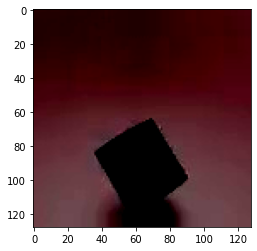

In [7]:
#### Define & Load Dataset

class GSLData(Dataset):
    """Custom GSL torch dataset"""
    def __init__(self, root, train=True, transform=None):
        super(GSLData, self).__init__()
        self.transform = transform
        self.groups = []
        
        all_ = os.listdir(root)
        train_len = int(len(all_)*0.8)
        group_dirs = all_[:train_len] if train else all_[train_len:]
        group_dirs = list(map(lambda x: os.path.join(root, x), group_dirs))
        
        for group_dir in group_dirs:
            group_data = {}
            for img_seq in os.listdir(group_dir):
                group_data[img_seq] = os.path.join(group_dir, img_seq)
            self.groups.append(group_data)

    def __getitem__(self, index):
        item = {}
        group = self.groups[index]
        for img_seq in group.keys():
            img_dir = group[img_seq]
            item[img_seq] = []
            for img_name in os.listdir(img_dir):
                img = plt.imread(os.path.join(img_dir, img_name))
                if self.transform is not None:
                    img = self.transform(img)
                item[img_seq].append(img.numpy())
            item[img_seq] = np.array(item[img_seq])
        return item

    def __len__(self):
        return len(self.groups)


data_root= 'group-gen/test-images'
trans = transforms.Compose([transforms.ToPILImage(),
                            transforms.Resize(128),
                            transforms.CenterCrop(128),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = (0.5, 0.5, 0.5), 
                                                 std = (0.5, 0.5, 0.5))])
train_data = GSLData(root=data_root, 
                     train=True, 
                     transform=trans)
test_data = GSLData(root=data_root, 
                    train=False, 
                    transform=trans)
train_loader = DataLoader(dataset=train_data, 
                          batch_size=1, 
                          shuffle=True)
test_loader = DataLoader(dataset=test_data, 
                         batch_size=1, 
                         shuffle=True)

for step, X in enumerate(test_loader):
    plt.imshow(X['000001'][0][0].numpy().transpose(1,2,0))
    print(X['000001'].shape)
    break

## Test AE

In [8]:
#### Test AE

class AE(nn.Module):
    def __init__(self,):
        super(AE, self).__init__()
    
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 4, 3, 1, 1),
            nn.ReLU(True),
            nn.Conv2d(4, 8, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(True),
        )
           
        self.decoder = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(64, 32, 3, 1, 1),
            nn.ReLU(True),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(32, 16, 3, 1, 1),
            nn.ReLU(True),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(16, 8, 3, 1, 1),
            nn.ReLU(True),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(8, 4, 3, 1, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 3, 3, 1, 1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# test_ae = AE().to(device)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(params=test_ae.parameters(), 
#                              lr=learning_rate, 
#                              weight_decay=weight_decay)
# for epoch in range(2):
#     for step, X in enumerate(test_loader):
#         print(X['center'].size(), X['center'].device)
#         inputs = X['center'].squeeze(0).to(device)
#         print(inputs.size(), inputs.device)
#         latent, outputs = test_ae(inputs)
#         print(latent.size(), latent.device)
#         print(outputs.size(), outputs.device)

#         loss = criterion(outputs, inputs)
#         print(f"Loss: {loss.item()}")
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

## Create Modules

In [9]:
#### Test LSTM modules

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.disentangler = M.DisEncoder(input_size=image_encoder_dim, 
                                         hidden_size=static_dim, 
                                         num_layers=disentangler_depth)
        self.dy_encoder = M.DyEncoder(input_size=static_dim, 
                                      hidden_size=dynamic_dim, 
                                      num_layers=1)
        self.dy_decoder = M.DyDecoder(input_size=dynamic_dim, 
                                      hidden_size=dynamic_dim,
                                      output_size=static_dim, 
                                      num_layers=1)
        self.dy_ae = M.DyModule(self.dy_encoder, 
                             self.dy_decoder, 
                             MAX_LENGTH)
        self.entangler = M.DisDecoder(input_size=static_dim+static_dim, 
                                      hidden_size=image_decoder_dim, 
                                      num_layers=entangler_depth)

    def forward(self, encoded_videos):
        # x.size() == (b, len, 3, 128, 128)
#         encoded_videos = torch.tensor([i for i in x])
        d_seq, statics = self.disentangler(encoded_videos)
        d_seq, masks, dynamics = self.dy_ae(d_seq)
        statics = statics.unsqueeze(1)
        s_seq = statics.repeat(1,MAX_LENGTH,1)
        new_z = torch.cat((s_seq,d_seq),dim=-1)
        videos_to_decode = self.entangler(new_z)[0]
        return videos_to_decode

## Test Training

In [11]:
#### Test training

cudnn.benchmark = True
image_ae = AE().to(device)
###
# Load AE weights here
###
for p in image_ae.parameters():  # Fix AE weights
    p.requires_grad=False

lstm = LSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=lstm.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)

for epoch in range(2):
    for step, X in enumerate(train_loader):
        # (b, dict)
        # X[group-key]: (1, len, 3, 128, 128)
        inputs = X['center'].squeeze(0).to(device)
        latent, outputs = image_ae(inputs)
        latent = latent.view(-1, 64*8*8).unsqueeze(0)
        rec_latent = lstm(latent)[:,:latent.size()[1],:]
#         print(rec_latent.size(), rec_latent.device)
        loss = criterion(rec_latent, latent)
        print(f'epoch: {epoch}, step: {step}, loss: {loss.item()}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

epoch: 0, step: 0, loss: 0.0006912598037160933
epoch: 0, step: 1, loss: 0.0005999046261422336
epoch: 0, step: 2, loss: 0.0005177875282242894
epoch: 0, step: 3, loss: 0.00045895640505477786
epoch: 0, step: 4, loss: 0.00038932269671931863
epoch: 0, step: 5, loss: 0.00032505844137631357
epoch: 0, step: 6, loss: 0.0002449426392558962
epoch: 0, step: 7, loss: 0.00015291714225895703
epoch: 0, step: 8, loss: 8.371736475965008e-05
epoch: 0, step: 9, loss: 6.383198342518881e-05
epoch: 0, step: 10, loss: 3.4911197872133926e-05
epoch: 0, step: 11, loss: 5.0464201194699854e-05
epoch: 0, step: 12, loss: 5.976805550744757e-05
epoch: 0, step: 13, loss: 7.000449841143563e-05
epoch: 0, step: 14, loss: 4.738819188787602e-05
epoch: 0, step: 15, loss: 6.188064435264096e-05
epoch: 0, step: 16, loss: 3.7389221688499674e-05
epoch: 0, step: 17, loss: 4.277942207409069e-05
epoch: 0, step: 18, loss: 3.0629991670139134e-05
epoch: 0, step: 19, loss: 4.451924905879423e-05
epoch: 0, step: 20, loss: 3.29402864736039